In [347]:
import os
import re
import json
import matplotlib.pyplot as plt
import pandas as pd
import glob

In [348]:
%matplotlib inline

In [349]:
NAME_REGEX = r"((checkpoint|events|args).*)|report-dev-m(?P<d>[^-]*)-(?P<s>[0-9]*)-(?P<t>train|eval|real)\.jsonl$"

In [389]:
def table_of_accuracies(label):
    print(label)
    [logdir] = glob.glob("../logdirs/{},*".format(label))
    data = []
    for f in os.listdir(logdir):
        if not f.endswith(".jsonl"): continue
        m = re.match(NAME_REGEX, f)
        assert m, "{} not a valid name".format(f)
        if m.group("d") is None:
            print(m)
            1/0
            continue
        data_source = m.group("t")
        data_label = m.group("d")
        checkpoint = int(m.group("s"))
        datatype = m.group("t")
        with open(os.path.join(logdir, f)) as fp:
            stats = json.loads(next(fp))
        if not stats.get('done', stats['total'] >= 2500):
            print(os.path.join(logdir, f))
            print(stats)
            continue
        
        data.append([label, checkpoint, stats['correct'] / stats['total'], stats['total'], data_source, data_label])
    df = pd.DataFrame(
        data, columns=['Model', 'Step', 'Accuracy', 'Total', 'DataSource', 'DataLabel']
    )
    return df


In [390]:
model_labels = """
vanilla
aggregate-standard
aggregate-with-io
#vanilla-real-nearai
#aggregate-with-io-real-nearai
vanilla-real-nearai-finetuned-1e-4
aggregate-with-io-real-nearai-finetuned-1e-4
vanilla-real-nearai-finetuned-rl-1e-5
aggregate-with-io-real-nearai-finetuned-rl-1e-5
vanilla-many-mutations
aggregate-with-io-many-mutations
""".strip().split("\n")
model_labels = [x for x in model_labels if x[0] != '#']

In [391]:
accuracies = [table_of_accuracies(x) for x in model_labels]
accuracies = pd.concat(accuracies)

vanilla
../logdirs/vanilla,trace_enc==none,batch_size==64,lr==1,lr_decay_steps=100000/report-dev-mnearai32,,greedy,,10-1500100-real.jsonl
{'total': 0, 'correct': 0, 'syntax-error': 0, 'runtime-exception': 0, 'done': False}
../logdirs/vanilla,trace_enc==none,batch_size==64,lr==1,lr_decay_steps=100000/report-dev-m1-500100-train.jsonl
{'total': 192, 'correct': 188, 'syntax-error': 0, 'runtime-exception': 0, 'done': False}
aggregate-standard
aggregate-with-io
vanilla-real-nearai-finetuned-1e-4
../logdirs/vanilla-real-nearai-finetuned-1e-4,data=nearai,pretr=vanilla,,1769300,trace_enc==none,batch_size==64,lr==0.0001,lr_decay_steps=100000/report-dev-mnearai,,greedy,,25-262200-real.jsonl
{'total': 640, 'correct': 349, 'syntax-error': 0, 'runtime-exception': 22, 'done': False}
aggregate-with-io-real-nearai-finetuned-1e-4
vanilla-real-nearai-finetuned-rl-1e-5
aggregate-with-io-real-nearai-finetuned-rl-1e-5
vanilla-many-mutations
aggregate-with-io-many-mutations


In [392]:
accuracies

,Model,Step,Accuracy,Total,DataSource,DataLabel
0,vanilla,850100,0.160271,443,real,"nearai32,,greedy,,5"
1,vanilla,50100,0.033860,443,real,"nearai32,,greedy,,1"
2,vanilla,750100,0.265193,905,real,nearai
3,vanilla,50100,0.216575,905,real,"nearai,,greedy,,5"
4,vanilla,600100,0.153499,443,real,"nearai32,,greedy,,5"
...,...,...,...,...,...,...
43,aggregate-with-io-many-mutations,100100,0.065463,443,real,"nearai32,,best_first,,1"
44,aggregate-with-io-many-mutations,50100,0.198895,905,real,"nearai,,greedy,,1"
45,aggregate-with-io-many-mutations,50100,0.396685,905,real,"nearai,,best_first,,25"
46,aggregate-with-io-many-mutations,100100,0.382320,905,real,"nearai,,best_first,,10"


In [407]:
overall_nearai_accuracies = accuracies[accuracies.DataLabel.map(lambda x: 'nearai,' in x)].copy()
overall_nearai_accuracies.Accuracy *= overall_nearai_accuracies.Total
overall_nearai_accuracies.Accuracy += 2500 - 975
overall_nearai_accuracies.Accuracy /= 2500
overall_nearai_accuracies = overall_nearai_accuracies[['Model', 'Step', 'DataLabel', 'Accuracy']].copy()
overall_nearai_accuracies.sort_values('Accuracy')

,Model,Step,DataLabel,Accuracy
160,vanilla,50100,"nearai,,best_first,,1",0.662
402,vanilla,50100,"nearai,,greedy,,1",0.662
44,aggregate-with-io-many-mutations,50100,"nearai,,greedy,,1",0.682
18,aggregate-with-io-many-mutations,50100,"nearai,,best_first,,1",0.682
41,aggregate-with-io,50100,"nearai,,greedy,,1",0.6872
...,...,...,...,...
350,vanilla,750100,"nearai,,best_first,,25",0.7904
23,aggregate-with-io,1028500,"nearai,,best_first,,25",0.7908
22,aggregate-standard,1043700,"nearai,,best_first,,25",0.7944
7,vanilla-real-nearai-finetuned-1e-4,262200,"nearai,,best_first,,10",0.7984


In [412]:
overall_nearai_accuracies = accuracies[accuracies.DataLabel.map(lambda x: 'nearai32,' in x)].copy()
overall_nearai_accuracies.Accuracy *= overall_nearai_accuracies.Total
overall_nearai_accuracies.Accuracy += 1950
overall_nearai_accuracies.Accuracy /= 2500
overall_nearai_accuracies = overall_nearai_accuracies[['Model', 'Step', 'DataLabel', 'Accuracy']].copy()
overall_nearai_accuracies.sort_values('Accuracy')

,Model,Step,DataLabel,Accuracy
1,vanilla,50100,"nearai32,,greedy,,1",0.786
150,vanilla,50100,"nearai32,,best_first,,1",0.786
0,aggregate-with-io-many-mutations,50100,"nearai32,,greedy,,1",0.7868
16,aggregate-with-io-many-mutations,50100,"nearai32,,best_first,,1",0.7868
312,vanilla,150100,"nearai32,,greedy,,1",0.7892
...,...,...,...,...
86,vanilla,1450100,"nearai32,,best_first,,25",0.828
57,vanilla,1100100,"nearai32,,best_first,,25",0.828
9,aggregate-standard,1043700,"nearai32,,best_first,,25",0.8288
2,aggregate-with-io,1028500,"nearai32,,best_first,,25",0.8292


In [395]:
max_step = accuracies.groupby(list(set(accuracies) - {'Step', 'Accuracy'})).transform(max).Step
just_max_step = accuracies[accuracies.Step == max_step]

In [396]:
def get_accuracies(model, data_source, data_label=None):
    selected_rows = (accuracies.Model == model) & (accuracies.DataSource == data_source)
    if data_label is not None:
        selected_rows &= accuracies.DataLabel == data_label
    return accuracies[selected_rows].pivot(index='Step', columns='DataLabel', values='Accuracy')
def plot_combined_accuracy(table, label):
    if not table.index.size:
        return
    cols = sorted(table.columns)
    result = sum(table[col] for col in cols) * 100 / len(cols)
    plt.plot(result, ".-", label=label)
    plt.xlabel("Step")
    plt.ylabel("Accuracy [%]")
    plt.legend()

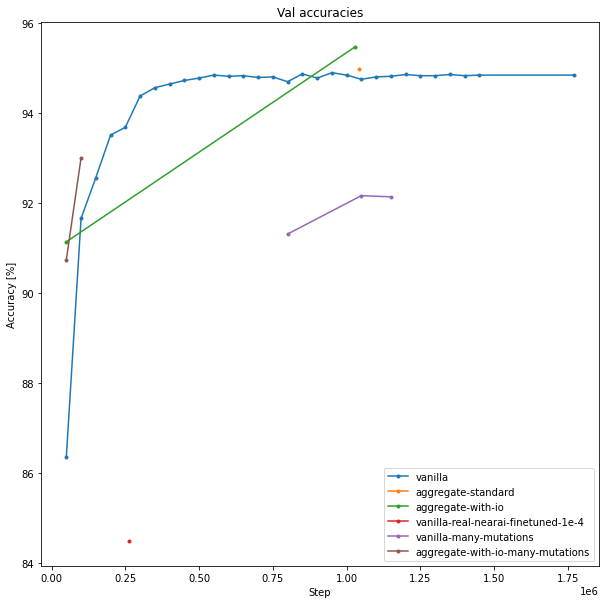

In [397]:
plt.figure(figsize=(10, 10))
plt.title("Val accuracies")
for model in model_labels:
    plot_combined_accuracy(get_accuracies(model, 'eval'), model)

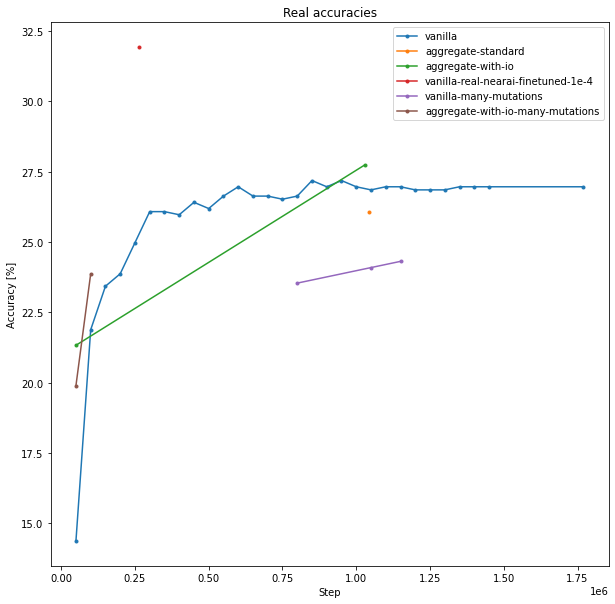

In [398]:
plt.figure(figsize=(10, 10))
plt.title("Real accuracies")
for model in model_labels:
    plot_combined_accuracy(get_accuracies(model, 'real', 'nearai'), model)

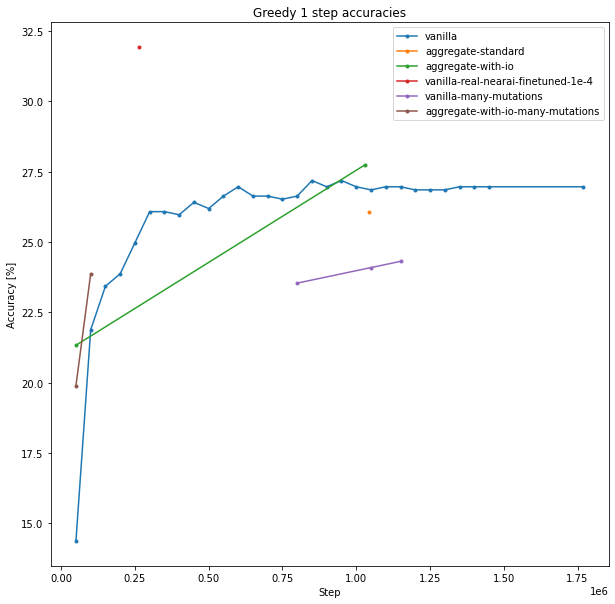

In [399]:
plt.figure(figsize=(10, 10))
plt.title("Greedy 1 step accuracies")
for model in model_labels:
    plot_combined_accuracy(get_accuracies(model, 'real', 'nearai,,greedy,,1'), model)

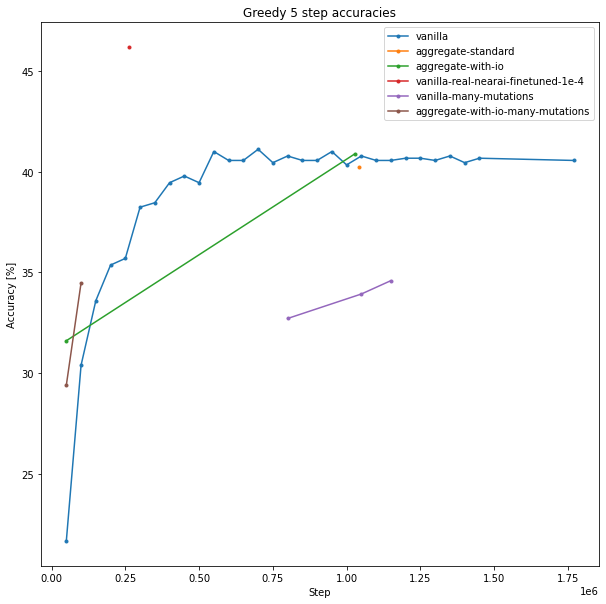

In [400]:
plt.figure(figsize=(10, 10))
plt.title("Greedy 5 step accuracies")
for model in model_labels:
    plot_combined_accuracy(get_accuracies(model, 'real', 'nearai,,greedy,,5'), model)

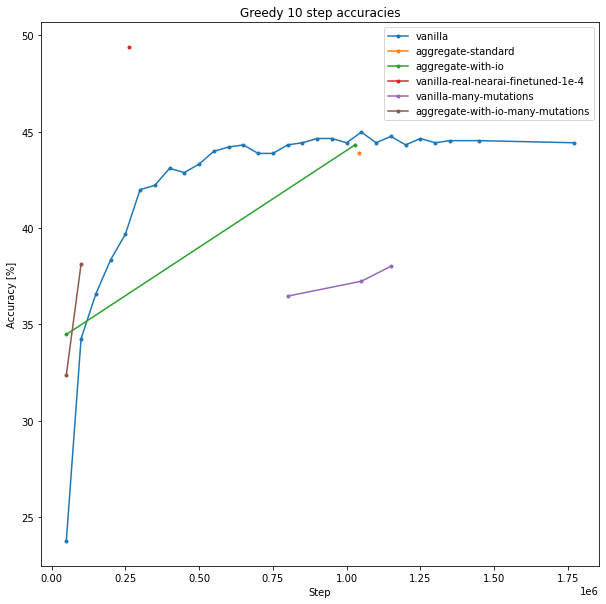

In [401]:
plt.figure(figsize=(10, 10))
plt.title("Greedy 10 step accuracies")
for model in model_labels:
    plot_combined_accuracy(get_accuracies(model, 'real', 'nearai,,greedy,,10'), model)

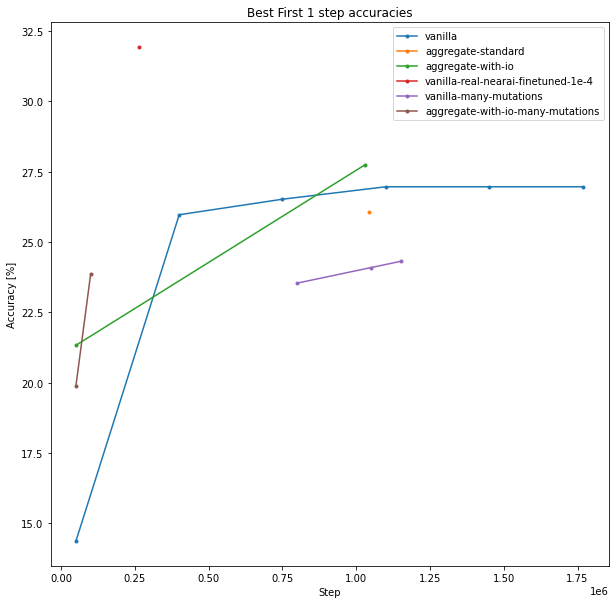

In [402]:
plt.figure(figsize=(10, 10))
plt.title("Best First 1 step accuracies")
for model in model_labels:
    plot_combined_accuracy(get_accuracies(model, 'real', 'nearai,,best_first,,1'), model)

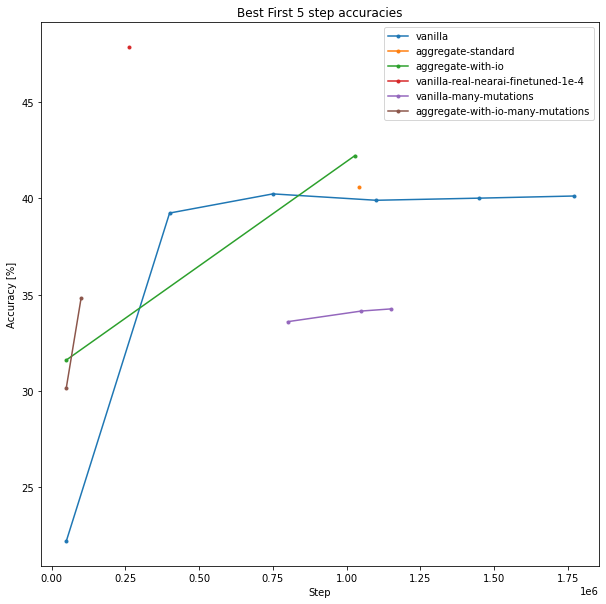

In [403]:
plt.figure(figsize=(10, 10))
plt.title("Best First 5 step accuracies")
for model in model_labels:
    plot_combined_accuracy(get_accuracies(model, 'real', 'nearai,,best_first,,5'), model)

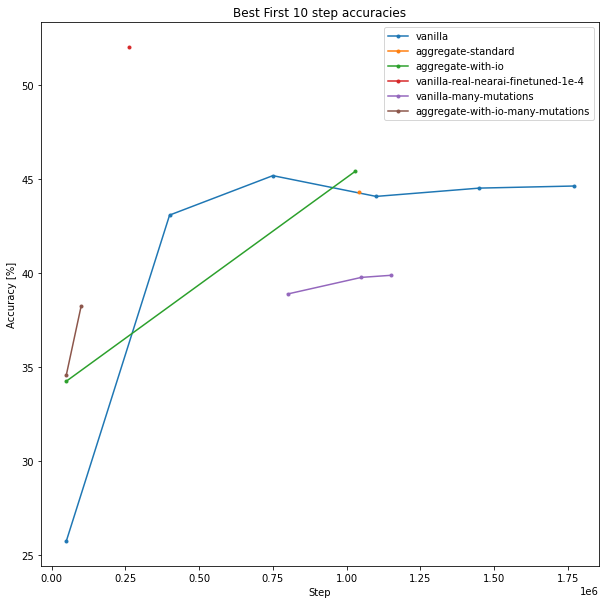

In [404]:
plt.figure(figsize=(10, 10))
plt.title("Best First 10 step accuracies")
for model in model_labels:
    plot_combined_accuracy(get_accuracies(model, 'real', 'nearai,,best_first,,10'), model)

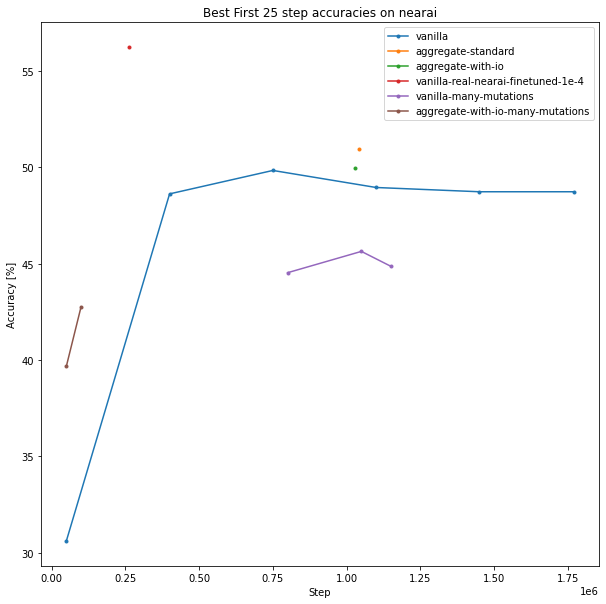

In [415]:
plt.figure(figsize=(10, 10))
plt.title("Best First 25 step accuracies on nearai")
for model in model_labels:
    plot_combined_accuracy(get_accuracies(model, 'real', 'nearai,,best_first,,25'), model)

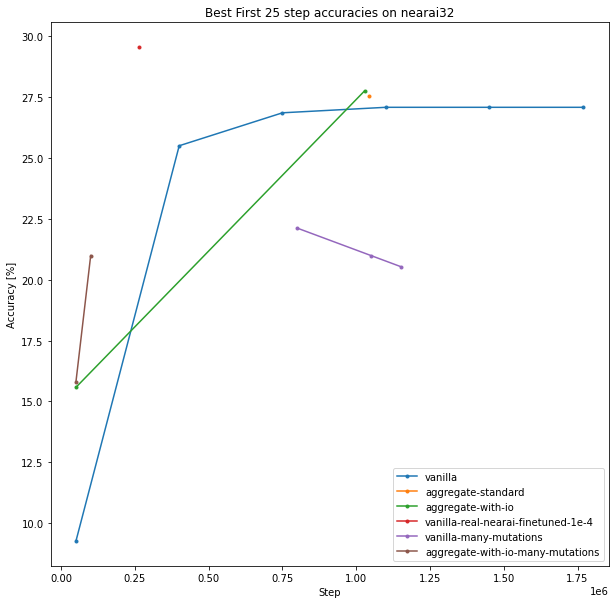

In [414]:
plt.figure(figsize=(10, 10))
plt.title("Best First 25 step accuracies on nearai32")
for model in model_labels:
    plot_combined_accuracy(get_accuracies(model, 'real', 'nearai32,,best_first,,25'), model)

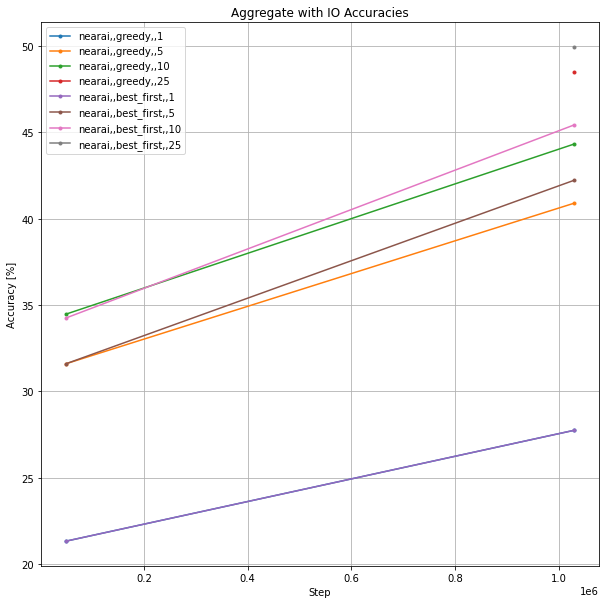

In [406]:
plt.figure(figsize=(10, 10))
plt.title("Aggregate with IO Accuracies")
for strat in "greedy", "best_first":
    for time in 1, 5, 10, 25:
        data_source = "nearai,,{},,{}".format(strat, time)
        plot_combined_accuracy(get_accuracies('aggregate-with-io', 'real', data_source), data_source)
plt.grid()